# ODC and Dask (LocalCluster) <img align="right" src="../../resources/csiro_easi_logo.png">

This notebook explores the use of ODC with Dask LocalCluster. The goal is to introduce fundamental concepts and the role Dask can serve with `datacube` and subsequent computation using `xarray`.

The example computation is fairly typical of an EO data processing pipeline. We'll be using a small area and time period to start with and progressively scaling this example. EO scientists may find some aspects of these examples unrealistic, but this isn't an EO science course. :-). 

For the base example we'll be using the Australian island state of Tasmania as our Region of Interest (ROI). Intially a paddock size, and progressively increasing to the entire island.
The basic algorithm is:
  1. Specify Region of Interest, Satellite product, EO satellite bands, Time range, desired CRS for the `datacube` query
  1. Load data using `datacube.load()`
  1. Mask valid data
  1. Visualisation of the ROI
  1. Compute NDVI
  1. Visualise NDVI
  
  
__Some cells in this notebook will take minutes to run so be patient__

In [112]:
# EASI tools
import git
import sys, os
os.environ['USE_PYGEOS'] = '0'
repo = git.Repo('.', search_parent_directories=True)
if repo.working_tree_dir not in sys.path: sys.path.append(repo.working_tree_dir)
from easi_tools import EasiNotebooks, notebook_utils
easi = EasiNotebooks()

In [113]:
import datacube
from datacube.utils import masking

The next cell sets out all the query parameters used in our `datacube.load()`.
For this run we keep the ROI quite small.

In [114]:
# Get the default latitude & longitude extents
study_area_lat = easi.latitude
study_area_lon = easi.longitude

# Or choose your own by uncommenting and modifying this section
###############################################################
# # Central Tasmania (near Little Pine Lagoon)
# central_lat = -42.019
# central_lon = 146.615

# # Set the buffer to load around the central coordinates
# # This is a radial distance for the bbox to actual area so bbox 2x buffer in both dimensions
# buffer = 0.05

# # Compute the bounding box for the study area
# study_area_lat = (central_lat - buffer, central_lat + buffer)
# study_area_lon = (central_lon - buffer, central_lon + buffer)
###############################################################

# Data product
product = easi.product('landsat')
# product = 'landsat8_c2l2_sr'

# Set the date range to load data over
set_time = easi.time
# set_time = ("2021-01-01", "2021-01-31")

# Set the measurements/bands to load. None will load all of them
measurements = None

# Set the coordinate reference system and output resolution
set_crs = easi.crs('landsat')  # If defined, else None
set_resolution = easi.resolution('landsat')  # If defined, else None
# set_crs = "epsg:3577"
# set_resolution = (-30, 30)

group_by = "solar_day"


Now initialise the `datacube`.

In [115]:
dc = datacube.Datacube()

# Access AWS "requester-pays" buckets
# This is necessary for reading data from most third-party AWS S3 buckets such as for Landsat and Sentinel-2
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True);

---
Now load the data. This first `dc.load()` does not use Dask, so it will take a little bit of time.

We use `%%time` to keep track of how long things take to complete.

In [116]:
%%time
dataset = None # clear results from any previous runs
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            group_by=group_by,
        )

CPU times: user 2.91 s, sys: 8.05 s, total: 11 s
Wall time: 19 s


The result of the `datacube.load()` function is an `xarray.Dataset`. The notebook can be used to render a description of the `dataset` variable as an html block with a _lot of useful information_ about the structure of data.
If you open up the `Data variables` (click the > Data variables) and click on the stacked cylinders for one of them you will see the actual data array is available and shown in summary form.

> __NOTE__ that you can see real numbers in the array when you do this. This will change when we start using Dask.

This visualisation will become increasingly importantly when dask is enabled and as scale out occurs so take a moment now to just poke around the interface. Depending on your area of interest set above, you should have a relatively small area (perhaps around 300 to 400 pixels in each of the `x` abd `y` dimensions) and perhaps up to 10 time slices. This is a relatively small scale and fine to do without using Dask.

In [117]:
dataset

<xarray.Dataset>
Dimensions:      (time: 10, y: 375, x: 303)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-08T15:47:05.354597 ... 2022-03...
  * y            (y) float64 4.109e+06 4.109e+06 ... 4.098e+06 4.098e+06
  * x            (x) float64 3.621e+05 3.621e+05 ... 3.711e+05 3.712e+05
    spatial_ref  int32 32618
Data variables:
    coastal      (time, y, x) uint16 8296 8193 8103 8129 ... 9641 10003 10847
    blue         (time, y, x) uint16 8491 8378 8294 8288 ... 9963 10366 11245
    green        (time, y, x) uint16 8907 8748 8664 8789 ... 10616 11094 12081
    red          (time, y, x) uint16 9048 8891 8788 8810 ... 11051 11563 12616
    nir08        (time, y, x) uint16 11423 10019 10039 ... 13313 13798 14158
    swir16       (time, y, x) uint16 10690 9976 9969 10628 ... 14499 15175 15619
    swir22       (time, y, x) uint16 9471 9182 9068 9253 ... 13204 13841 14799
    qa_pixel     (time, y, x) uint16 21824 21824 21824 ... 21824 21824 21824
    qa_aerosol   (time, y, x) uint8 89 96 89 89 96 89 89 ... 89 96 89 89 96 89
    qa_radsat    (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:32618
    grid_mapping:  spatial_ref

Next up filter out pixels which are affect by clouds and other issues and compute the NDVI. Since we aren't specifying a time range this will be performed for all images.

In [118]:
%%time
# Identify pixels that don't have cloud, cloud shadow or water
from datacube.utils import masking

good_pixel_flags = {
    'nodata': False,
    'cloud': 'not_high_confidence',
    'cloud_shadow': 'not_high_confidence',
    'water': 'land_or_cloud'
}

cloud_free_mask = masking.make_mask(dataset['qa_pixel'], **good_pixel_flags)

# Apply the mask
cloud_free = dataset.where(cloud_free_mask)

# Calculate the components that make up the NDVI calculation
band_diff = cloud_free.nir08 - cloud_free.red
band_sum = cloud_free.nir08 + cloud_free.red
# Calculate NDVI
ndvi = None
ndvi = band_diff / band_sum

CPU times: user 29.8 ms, sys: 0 ns, total: 29.8 ms
Wall time: 30 ms


The result `ndvi` is an `xarray.DataArray`. Let's take a look at it. Again the notebook will render an html version of the data in summary form.
Notice again the actual data values are being shown and that there are the same number of time slices as above and the x and y dimensions are identical.

In [119]:
ndvi

<xarray.DataArray (time: 10, y: 375, x: 303)>
array([[[0.11601778, 0.05965098, 0.06644712, ..., 0.20393186,
         0.22970533, 0.23700887],
        [0.04323258, 0.05291651, 0.07384295, ..., 0.16208063,
         0.18459483, 0.22063243],
        [       nan, 0.05829736, 0.08907363, ...,        nan,
         0.07845528, 0.15509878],
        ...,
        [       nan,        nan,        nan, ..., 0.10887829,
         0.04116832, 0.02674366],
        [       nan,        nan,        nan, ..., 0.10240742,
         0.06274668, 0.03096596],
        [       nan,        nan,        nan, ..., 0.08492462,
         0.0783455 , 0.04489265]],

       [[0.1021141 , 0.03340714, 0.04916924, ..., 0.20503221,
         0.22844267, 0.24527661],
        [       nan, 0.04990829, 0.07342523, ..., 0.17086283,
         0.19181934, 0.22505252],
        [       nan, 0.05123793, 0.10448173, ..., 0.08468649,
         0.09496585, 0.16799334],
...
        [       nan,        nan,        nan, ..., 0.11447655,
         0.05836152, 0.03827954],
        [       nan,        nan,        nan, ..., 0.09906943,
         0.07535781, 0.04281965],
        [       nan,        nan,        nan, ..., 0.0863381 ,
         0.08378773, 0.05796038]],

       [[0.07949372, 0.06102855, 0.07568831, ..., 0.19272977,
         0.216446  , 0.2347246 ],
        [0.06098176, 0.08288149, 0.09702055, ..., 0.11634974,
         0.15610579, 0.20491937],
        [0.05187615, 0.0712673 , 0.10636558, ..., 0.06973621,
         0.10066805, 0.17526375],
        ...,
        [       nan,        nan,        nan, ..., 0.1208527 ,
         0.05549854, 0.03641194],
        [       nan,        nan,        nan, ..., 0.1068145 ,
         0.07744892, 0.04051173],
        [       nan,        nan,        nan, ..., 0.0928419 ,
         0.08812744, 0.05759319]]])
Coordinates:
  * time         (time) datetime64[ns] 2022-01-08T15:47:05.354597 ... 2022-03...
  * y            (y) float64 4.109e+06 4.109e+06 ... 4.098e+06 4.098e+06
  * x            (x) float64 3.621e+05 3.621e+05 ... 3.711e+05 3.712e+05
    spatial_ref  int32 32618

Raw numbers aren't nice to look at so let's draw a time slice. We'll select just one of them to draw and pick one that didn't get masked out by cloud completely. You can see that all clouds and water has been masked out so that we are just looking at the NDVI of the land area.

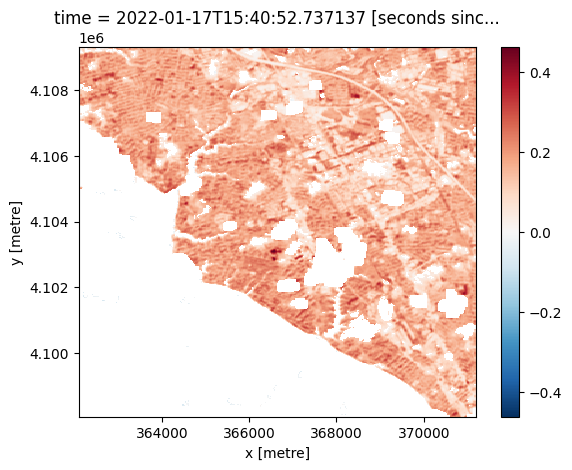

In [120]:
ndvi.isel(time=1).plot()

# Exploring Dask with the ODC - Concepts

Let's set our time range to a couple of weeks, or approximately two passes of Landsat 8 for this ROI. Less data will allow us to explore how dask works with the `datacube` and `xarray` libraries.

In [121]:
set_time = ("2021-01-01", "2021-01-14")

In [122]:
%%time
dataset = None # clear results from any previous runs
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            group_by=group_by,
        )
dataset

CPU times: user 720 ms, sys: 1.5 s, total: 2.22 s
Wall time: 4.32 s


<xarray.Dataset>
Dimensions:      (time: 2, y: 375, x: 303)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-05T15:47:05.923026 2021-01-14T...
  * y            (y) float64 4.109e+06 4.109e+06 ... 4.098e+06 4.098e+06
  * x            (x) float64 3.621e+05 3.621e+05 ... 3.711e+05 3.712e+05
    spatial_ref  int32 32618
Data variables:
    coastal      (time, y, x) uint16 41676 38256 34888 ... 23681 23353 23241
    blue         (time, y, x) uint16 42973 39496 35785 ... 23526 23282 23241
    green        (time, y, x) uint16 41367 37694 33999 ... 22786 22689 22695
    red          (time, y, x) uint16 42248 38600 34682 ... 23009 22838 22773
    nir08        (time, y, x) uint16 42560 39248 35369 ... 24014 23904 23781
    swir16       (time, y, x) uint16 31132 28388 25520 ... 14395 14412 14428
    swir22       (time, y, x) uint16 26539 24310 21665 ... 14796 14793 14805
    qa_pixel     (time, y, x) uint16 22280 22280 22280 ... 55052 55052 55052
    qa_aerosol   (time, y, x) uint8 216 224 216 216 224 ... 168 208 184 152 160
    qa_radsat    (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:32618
    grid_mapping:  spatial_ref

As before you can see the actual data in the results but this time there should only be 1 or 2 observation times

Now let's create a `LocalCluster` as we did in the earlier notebook.

In [123]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45221,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.00 GiB
Comm: tcp://127.0.0.1:45281,Total threads: 2
Dashboard: http://127.0.0.1:44675/status,Memory: 7.25 GiB
Nanny: tcp://127.0.0.1:40519,


You may like to open up the dashboard for the cluster, although for this notebook we won't be talking about the dashboard (that's for a later discussion).

In [124]:
notebook_utils.localcluster_dashboard(client=client,server=easi.hub)

'https://hub.eail.easi-eo.solutions/user/jhodge/proxy/8787/status'

---
Now that we are using a cluster, even though it is local, we need to make sure that our cluster has the right configuration to use __Requester Pays__ buckets in AWS S3. To do this, we need to re-run the `configure_s3_access()` function that we ran earlier, but we need to pass the `client` to the function as well.

In [125]:
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

`datacube.load()` will use the default `dask` cluster (the one we just created) __if the `dask_chunks` parameter is specified__.

The chunk shape and memory size is a critial parameter in tuning `dask` and we will be discussing it in great detail as scale increases. For now we're simply going to specify that the `time` dimension should individually chunked (`1` slice of time) and by not specifying any chunking for the other dimensions they will be form a single contiguous block.

If that made no sense what's so ever, that's fine because we will look at an example.

In [126]:
chunks = {"time":1}

In [127]:
%%time
dataset = None # clear results from any previous runs
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = chunks, ###### THIS IS THE ONLY LINE CHANGED. #####
            group_by=group_by,
        )
dataset

CPU times: user 22.4 ms, sys: 4.8 ms, total: 27.2 ms
Wall time: 33.9 ms


<xarray.Dataset>
Dimensions:      (time: 2, y: 375, x: 303)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-05T15:47:05.923026 2021-01-14T...
  * y            (y) float64 4.109e+06 4.109e+06 ... 4.098e+06 4.098e+06
  * x            (x) float64 3.621e+05 3.621e+05 ... 3.711e+05 3.712e+05
    spatial_ref  int32 32618
Data variables:
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 375, 303), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 375, 303), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 375, 303), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 375, 303), meta=np.ndarray>
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 375, 303), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 375, 303), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 375, 303), meta=np.ndarray>
    qa_pixel     (time, y, x) uint16 dask.array<chunksize=(1, 375, 303), meta=np.ndarray>
    qa_aerosol   (time, y, x) uint8 dask.array<chunksize=(1, 375, 303), meta=np.ndarray>
    qa_radsat    (time, y, x) uint16 dask.array<chunksize=(1, 375, 303), meta=np.ndarray>
Attributes:
    crs:           epsg:32618
    grid_mapping:  spatial_ref

First thing you probably noticed is that whilst only one line changed the load time dropped to sub-seconds!
The second thing you probably noticed is if you look at one of the `data variables` by clicking on the database icon as before, there is no data but instead there is a  diagram which shows you the __Dask Chunks__ for each measurement. It's really fast because it didn't actually load any data!

When `datatcube` has `dask_chunks` specified it switches from creating `xarrays` to instead use `dask.arrays` in the backend and `lazy loads` them - this means that __no data is loaded until used__. If you look at one of the data variables you will see it now has `dask.array<chunksize=(....)>` rather than values and the cylinder icon will show the Array _and_ Chunk parameters along with some statistics, not actual data.

The `datacube.load()` has used the `dask.Delayed` interface which will not perform any `tasks` (Dask's name for `calculations`) until the _result_ of the `task` is actually required. We'll load the data in a moment but first let's take a look at the parameters in that pretty visualisation. Click on the cylinder for the `red` Data variables and look at the table and the figure. It should look similar to the image below.

<img src="../../resources/dask_array_example_small.png">

Looking at this image (yours may be different), you can see that:
  1. The Array is `221.92 kiB` in total size and is broken into Chunks which have size `110.96 kiB`
  2. The Array shape is `(2, 375, 303) (time, y, x)` but each chunk is `(1,375,303)` because we specified the `time` dimension should have chunks of length `1`.
  3. There are `2` chunk tasks, one for each time slice and in this instance, only one graph layer. More complex calculations will have more layers in the graph.
  4. The Array type is `uint16` and is split up into chunks which are `numpy.ndarrays`.
  
The chunking has split the array loading into two Chunks. __Dask can execute these in parallel.__

We can look at the delayed tasks and how they will be executed by visualising the task graph for one of the variables. We'll use the red band measurement.

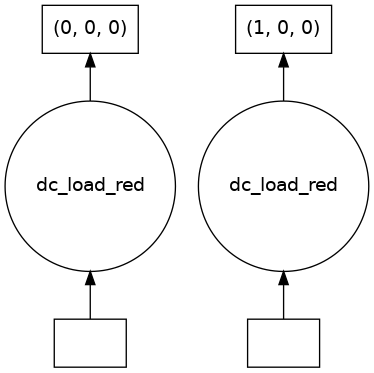

In [128]:
dataset.red.data.visualize()

Details on the task graph can be found in the dask user guide but what's clear is you have two independent paths of execution which produce one time slice each (0,0,0) and (1,0,0) these are the two chunks that that full array has been split into.

To retrieve the actual data we need to `compute()` the result, this will cause all the delayed tasks to be executed for the variable we are computing. Let's `compute()` the red variable.

In [129]:
%%time
actual_red = dataset.red.compute()
actual_red

CPU times: user 51.8 ms, sys: 7.4 ms, total: 59.2 ms
Wall time: 1.1 s


<xarray.DataArray 'red' (time: 2, y: 375, x: 303)>
array([[[42248, 38600, 34682, ..., 20596, 18056, 16344],
        [42801, 39394, 35839, ..., 18729, 17135, 16158],
        [41828, 39168, 36530, ..., 17681, 16408, 15873],
        ...,
        [17321, 15368, 16238, ..., 15783, 15816, 14927],
        [16222, 15001, 14961, ..., 15806, 15287, 14640],
        [13755, 12959, 12154, ..., 15680, 15168, 14639]],

       [[13928, 13882, 13841, ..., 15438, 15274, 15093],
        [13876, 13989, 13921, ..., 15444, 15215, 15049],
        [13812, 14012, 14099, ..., 15526, 15244, 15038],
        ...,
        [16635, 17086, 17291, ..., 22777, 22790, 22751],
        [16388, 17009, 17333, ..., 23118, 22967, 22838],
        [16335, 16892, 17286, ..., 23009, 22838, 22773]]], dtype=uint16)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-05T15:47:05.923026 2021-01-14T...
  * y            (y) float64 4.109e+06 4.109e+06 ... 4.098e+06 4.098e+06
  * x            (x) float64 3.621e+05 3.621e+05 ... 3.711e+05 3.712e+05
    spatial_ref  int32 32618
Attributes:
    units:         reflectance
    nodata:        0
    crs:           epsg:32618
    grid_mapping:  spatial_ref

As you can see we now have actual data (there are real numbers, not just Dask arrays). You can do the same thing for all arrays in the dataset in one go by computing the dataset itself.

In [130]:
%%time
actual_dataset = dataset.compute()
actual_dataset

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 107 ms, sys: 17.3 ms, total: 124 ms
Wall time: 1.75 s


<xarray.Dataset>
Dimensions:      (time: 2, y: 375, x: 303)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-05T15:47:05.923026 2021-01-14T...
  * y            (y) float64 4.109e+06 4.109e+06 ... 4.098e+06 4.098e+06
  * x            (x) float64 3.621e+05 3.621e+05 ... 3.711e+05 3.712e+05
    spatial_ref  int32 32618
Data variables:
    coastal      (time, y, x) uint16 41676 38256 34888 ... 23681 23353 23241
    blue         (time, y, x) uint16 42973 39496 35785 ... 23526 23282 23241
    green        (time, y, x) uint16 41367 37694 33999 ... 22786 22689 22695
    red          (time, y, x) uint16 42248 38600 34682 ... 23009 22838 22773
    nir08        (time, y, x) uint16 42560 39248 35369 ... 24014 23904 23781
    swir16       (time, y, x) uint16 31132 28388 25520 ... 14395 14412 14428
    swir22       (time, y, x) uint16 26539 24310 21665 ... 14796 14793 14805
    qa_pixel     (time, y, x) uint16 22280 22280 22280 ... 55052 55052 55052
    qa_aerosol   (time, y, x) uint8 216 224 216 216 224 ... 168 208 184 152 160
    qa_radsat    (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:32618
    grid_mapping:  spatial_ref

## The impact of dask on ODC

From the above we can see that specifying `dask_chunks` in `datacube.load()` splits up the `load()` operation into a set of `chunk` shaped arrays and `delayed` _tasks_. Dask can now perform those tasks in _parallel_. Dask will only _compute_ the results for those parts of the data we are using but we can force the computation of all the `delayed` _tasks_ using `compute()`.

There is a _lot_ more opportunity than described in this simple example but let's just focus on the impact of dask on ODC for this simple case.

The time period and ROI are far too small to be interesting so let's change our time range to a full year of data.

In [ ]:
set_time = ("2021-01-01", "2021-12-31")

First load the data without dask (no `dask_chunks` specified).
> __NOTE__ that this will take several minutes so be patient

In [ ]:
%%time
dataset = None # clear results from any previous runs
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            group_by=group_by,
        )
dataset

There should now be around 40 or more time observations and in the order of 3-5 minutes to load.

Let's enable dask and repeat the load. We're chunking by time (length one) so dask will be able to load each time slice in parallel. The data variables are also independent so will be done in parallel as well.

In [ ]:
chunks = {"time":1}

In [ ]:
%%time
dataset = None # clear results from any previous runs
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = chunks, ###### THIS IS THE ONLY LINE CHANGED. #####
            group_by=group_by,
        )
dataset

Woah!! that was fast - but we didn't actually compute anything so no load has occurred and all tasks are pending.
Open up the Data Variables, click the stacked cylinders and take a look at the delayed task counts. These exist for every variable.

Let's visualise the _task graph_ for the `red` band.

In [ ]:
dataset.red.data.visualize()

Well that's not as useful, is it!

You should just be able to make out that each of the _chunks_ are able to independently `load()`. `time` _chunk_ is length 1 so these are individual times. This holds true for all the bands so dask can spread these out across multiple threads.

> __Tip__: Visualising task graphs is less effective as your task graph complexity increases. You may need to use simpler examples to see what is going on.

Let's get the actual data

In [ ]:
%%time
actual_dataset = dataset.compute()
actual_dataset

How fast this step is will depend on how many cores are in your Jupyter notebook's local cluster. In real world scenarios, an 8-core cluster the `datacube.load()` this may take between 1/4 or 1/6 of the time compared to without `dask` depending on many factors. This is great!

Why not 1/8 of the time?

Dask has overheads, and `datacube.load()` itself is IO limited. There are all sorts of things that result in limits and part of the art of parallel computing is tuning your algorithm to reduce the impact of these and achieve greater performnance. As we scale up this example we'll explore some of these.

> __Tip__: recent updates to Dask have greatly improved performance and we are now seeing more substantial performance gains, more in line with the increase in cores.
>
> Do not always expect 8x as many cores to produce 8x the speed up. Algorithms can be tuned to perform better (or worse) as scale increases. This is part of the art of parallel programming. Dask does it's best, and you can often do better.

# Exploiting delayed tasks

Now let's repeat the full example, with NDVI calculation and masking, but this time with `dask` and `compute` to load the data in.

First the `dc.load()`...

In [ ]:
chunks = {"time":1}

This time, we will run the `.compute()` step straight away, resulting in real numbers being returned from Dask.

In [ ]:
%%time
dataset = None # clear results from any previous runs
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = chunks,
            group_by=group_by,
        )
actual_dataset = dataset.compute()

In [ ]:
actual_dataset

Now use the `actual_result` to compute the NDVI for all observation times

In [ ]:
# Identify pixels that don't have cloud, cloud shadow or water
cloud_free_mask = masking.make_mask(actual_dataset['qa_pixel'], **good_pixel_flags)

# Apply the mask
cloud_free = actual_dataset.where(cloud_free_mask)

# Calculate the components that make up the NDVI calculation
band_diff = cloud_free.nir08 - cloud_free.red
band_sum = cloud_free.nir08 + cloud_free.red
# Calculate NDVI and store it as a measurement in the original dataset ta da
ndvi = None
ndvi = band_diff / band_sum

This completed very quickly because most of the time is in the data load, the actual calculation is < 1 second.

---
Now let's repeat that entire load and NDVI calculation in a single cell and time it - this is just to get the total time for later comparison.

To ensure comparable timings, we will `.restart()` the Dask cluster. This makes sure that we aren't just seeing performance gains for data caching.
> __Note__ that this will show some `Restarting worker` warnings. That is ok and it is just telling you that each of the four workers in the cluster are restarting.

In [ ]:
client.restart()

In [ ]:
%%time
dataset = None # clear results from any previous runs
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = chunks, 
            group_by=group_by,
        )
actual_dataset = dataset.compute() ### Compute the dataset ###

# Identify pixels that don't have cloud, cloud shadow or water
cloud_free_mask = masking.make_mask(actual_dataset['qa_pixel'], **good_pixel_flags)

# Apply the mask
cloud_free = actual_dataset.where(cloud_free_mask)

# Calculate the components that make up the NDVI calculation
band_diff = cloud_free.nir08 - cloud_free.red
band_sum = cloud_free.nir08 + cloud_free.red
# Calculate NDVI and store it as a measurement in the original dataset ta da
ndvi = None
ndvi = band_diff / band_sum

around 10 seconds (for an 8-core cluster) or so. We can do better...

## Data and computational locality

When `compute()` is called `dask` not only executes all the tasks but it consolidates all the distributed chunks back into a normal array on the client machine - in this case the notebook's kernel. In the previous cell we have two variables that both refer to the data we are loading:
1. _dataset_ refers to the `delayed` version of the data. The `delayed` _tasks_ and the _chunks_ that make it up will be __on the cluster__
2. _actual_result_ refers to the actual array in the notebook kernel memory after execution of the _tasks_. The _actual_result_ is a complete array in memory in the notebook kernel (__on the _client___).

So in the previous cell everything _after_ the `actual_dataset = dataset.compute()` line is computed in the Jupyter kernel and doesn't use the dask cluster at all for computation.

If we shift the location of this `compute()` call we can perform more _tasks_ in parallel on the dask cluster. 

> __Tip__: Locality is an important concept and applies to both data and computation

Now let's repeat the load and NDVI calculation but this time rather than `compute()` on the full `dataset` we'll run the compute at the cloud masking step (`cloud_free = dataset.where(cloud__free_mask).compute()`) so the masking operation can be performed in parallel. Let's see what the impact is...


In [ ]:
client.restart()

In [ ]:
%%time
dataset = None # clear results from any previous runs
del dataset
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = chunks, 
            group_by=group_by,
        )

# Identify pixels that are either "valid", "water" or "snow"
cloud_free_mask = masking.make_mask(dataset['qa_pixel'], **good_pixel_flags)

# Apply the mask
cloud_free = dataset.where(cloud_free_mask).compute()    ### COMPUTE MOVED HERE ###

# Calculate the components that make up the NDVI calculation
band_diff = cloud_free.nir08 - cloud_free.red
band_sum = cloud_free.nir08 + cloud_free.red
# Calculate NDVI and store it as a measurement in the original dataset ta da
ndvi = None
ndvi = band_diff / band_sum
actual_ndvi = ndvi

Not that different, but still a second or so quicker. This isn't too surprising since the masking operation is pretty quick (it's all numpy) and the data load is the bulk of the processing.

Dask can see the entire task graph for both load and mask computation. As a result _some_ of the computation can be performed concurrently with file IO, and CPUs are busier as a result, so it will be slightly faster in practice but with IO dominating we won't see much overall improvement.

Perhaps doing more of the calculation on the cluster will help. Let's also move `ndvi.compute()` so the entire calculation is done on the cluster and only the final result returned to the client.

In [ ]:
client.restart()

In [ ]:
%%time
dataset = None # clear results from any previous runs
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = chunks, 
            group_by=group_by,
        )

# Identify pixels that don't have cloud, cloud shadow or water
cloud_free_mask = masking.make_mask(dataset['qa_pixel'], **good_pixel_flags)

# Apply the mask
cloud_free = dataset.where(cloud_free_mask)

# Calculate the components that make up the NDVI calculation
band_diff = cloud_free.nir08 - cloud_free.red
band_sum = cloud_free.nir08 + cloud_free.red
# Calculate NDVI and store it as a measurement in the original dataset ta da
ndvi = None
ndvi = band_diff / band_sum
actual_ndvi = ndvi.compute()    ### COMPUTE MOVED HERE ###

Now we are seeing a huge difference!

You may be thinking "Hold on a sec, the NDVI calculation is pretty quick in this example with such a small dataset, why such a big difference?" - and you'd be right. There is more going on.

Remember that `dataset` is a _task graph_ with `delayed` tasks waiting to be executed __when the result is required__. In the example `dataset`, there are many data variables are available but _only 3 are used_ to produce the `ndvi` (`qa_pixel`, `red` and `nir08`). As a result _`dask` doesn't load the other variables_ and because computation time in this case is mostly IO related the execution time is a LOT faster.

Of course we can save `dask` the trouble of figuring this out on our behalf and only `load()` the `measurements` we need in the first place. Let's check that now, we should see a similar performance figure.


In [ ]:
client.restart()

In [ ]:
%%time
dataset = None # clear results from any previous runs
measurements = [ "qa_pixel", "red", "nir08"]
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = chunks, 
            group_by=group_by,
        )

# Identify pixels that don't have cloud, cloud shadow or water
cloud_free_mask = masking.make_mask(dataset['qa_pixel'], **good_pixel_flags)
# Apply the mask
cloud_free = dataset.where(cloud_free_mask)

# Calculate the components that make up the NDVI calculation
band_diff = cloud_free.nir08 - cloud_free.red
band_sum = cloud_free.nir08 + cloud_free.red
# Calculate NDVI and store it as a measurement in the original dataset ta da
ndvi = None
ndvi = band_diff / band_sum
actual_ndvi = ndvi.compute()

Pretty similar as expected, but again, a slight improvement because now there are less overheads and a smaller task graph.
Now it can pay to give `dask` a hand and not have the _task graph_ cluttered with tasks you are not going to use. Still it's nice to see that `dask` can save you some time by only computing what is required when you need it.

# A quick check on the task graph

For completeness we will take a look at the _task graph_ for the full calculation, all the way to the NDVI result. Given the complexity of the full graph we'll simplify it to 2 time observations like we did when the task graph was introduced previously.


In [ ]:
set_time = ("2021-01-01", "2021-01-14")

In [ ]:
client.restart()

In [ ]:
%%time
dataset = None # clear results from any previous runs
measurements = [ "qa_pixel", "red", "nir08"]
dataset = dc.load(
            product=product,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling={"qa_pixel": "nearest", "*": "average"},
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = chunks, 
            group_by=group_by,
        )

# Identify pixels that don't have cloud, cloud shadow or water
cloud_free_mask = masking.make_mask(dataset['qa_pixel'], **good_pixel_flags)
# Apply the mask
cloud_free = dataset.where(cloud_free_mask)

# Calculate the components that make up the NDVI calculation
band_diff = cloud_free.nir08 - cloud_free.red
band_sum = cloud_free.nir08 + cloud_free.red
# Calculate NDVI and store it as a measurement in the original dataset ta da
ndvi = None
ndvi = band_diff / band_sum


In [ ]:
ndvi.data.visualize()

The computation flows from __bottom to top__ in the _task graph_. You can see there are two main paths, one for each time (since the time chunk is length 1). You can also see the three data sources are loaded independently. After that it gets a little more difficult to follow but you can see `qa_pixel` being used to produce the mask (_and\__, _eq_). Then combined via the `where` function with other two datasets. Then finally the NDVI calculation - a sub, add and divide (truediv).

Dask has lots of internal optimizations that it uses to help identify the dependencies and parallel components of a task graph. Sometimes it will reorder or prune operations where possible to further optimise (for example, not loading _data variables_ that aren't used in the NDVI calculation).

> __Tip__: The _task graph_ can be complex but it is a useful tool in understanding your algorithm and how it scales.

# Be a good dask user - Clean up the cluster resources

In [ ]:
client.close()

cluster.close()